## Train set, reference set 나누기
Image retrieval task에서는 일반적인 classification task와는 다르게 reference set과 query set이 존재합니다. 

- reference set : 학습이 완료된 모델에 통과시킨 후 feature vector들을 임베딩하기 위해 사용됩니다. 
- query set : 흔히 지금까지 알아 온 test set으로, 임베딩된 reference set의 feature vector들로부터 query image의 feature vector가 얼마나 멀리 떨어져 있는지 계산하기 위해 사용됩니다. 

Image retrieval task에서는 학습된 모델을 feature extractor로 사용해 수십~수백 장의 reference images를 임베딩합니다. 이후 query image가 들어오면 query image도 마찬가지로 학습된 모델에 통과시켜 feature vector를 얻어낸 후 사전에 임베딩된 reference image feature vector들과 유사도를 구하게 됩니다. 이 유사도가 높은 순으로 결과를 정렬해 보여주는 것이 image retrieval task입니다. 

이 노트북에서는 전체 이미지 데이터셋을 `Train set`과 `Reference set`으로만 나눕니다. `Query set`은 구글링을 통해 따로 모을 예정입니다. 

In [1]:
import os
import pandas as pd

dataset_path = './../../../KPopGirls/Images'
filenames = os.listdir(dataset_path)

In [2]:
import re

celebnameonly_list = []

for name in os.listdir(dataset_path):
    celebnameonly_list.append(re.sub('[^a-zA-Z]', '', str(name.split('.')[0])))
    
unique_celeb_names = sorted(list(set(celebnameonly_list)))
len(unique_celeb_names)

25

In [3]:
celeb_df = pd.DataFrame(filenames, columns=['filename'])
celeb_df['celebname'] = celeb_df['filename']
celeb_df['celebname'] = celeb_df['celebname'].str.replace('\d+.jpg', '')

In [4]:
celeb_df.head(5)

,filename,celebname
0,arin001.jpg,arin
1,arin002.jpg,arin
2,arin003.jpg,arin
3,arin004.jpg,arin
4,arin005.jpg,arin


In [5]:
i = 0
celeb_df_groups = []

for name, group in celeb_df.groupby('celebname'):
    group['class']=i
    i+=1
    celeb_df_groups.append(group)
celeb_df = pd.concat(celeb_df_groups).set_index('filename')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
celeb_df.head(5)

,celebname,class
filename,,
arin001.jpg,arin,0
arin002.jpg,arin,0
arin003.jpg,arin,0
arin004.jpg,arin,0
arin005.jpg,arin,0


## Force sampling 20 images per class from `celeb_df` dataframe

이제, 각 `class`로부터 랜덤하게 20장씩 샘플링해 `reference set`을 만든 후 `celeb_df`에서 `reference set`을 제거해 `train_celeb_df`와 `reference_celeb_df`를 생성하겠습니다.

In [7]:
sampled_class_df_list = []
for index, group in celeb_df.groupby(celeb_df['celebname']):
    sampled_df = group.sample(n=20)
    sampled_class_df_list.append(sampled_df)
reference_celeb_df = pd.concat(sampled_class_df_list).sort_values('filename')

In [8]:
reference_celeb_df.head(5)

,celebname,class
filename,,
arin031.jpg,arin,0
arin038.jpg,arin,0
arin047.jpg,arin,0
arin051.jpg,arin,0
arin055.jpg,arin,0


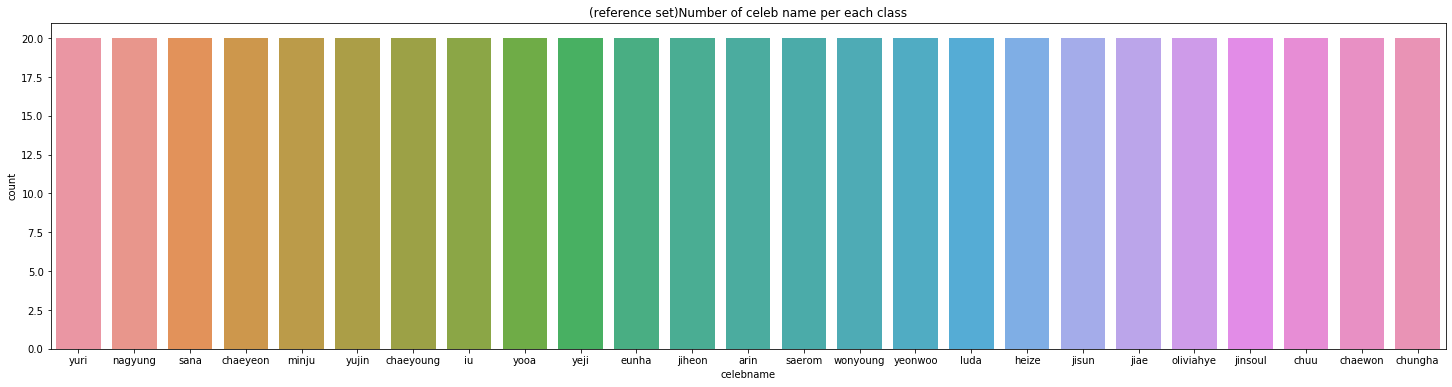

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6)) # class id가 겹쳐 출력되지 않게 고의로 가로 사이즈를 늘렸습니다.
sns.countplot(reference_celeb_df["celebname"], order=reference_celeb_df["celebname"].value_counts(ascending=True).index)
plt.title("(reference set)Number of celeb name per each class")
plt.show()

강제로 test dataframe을 만들었으니, `celeb_df` 데이터프레임에서 `train set`만 분리해 보겠습니다.

In [10]:
train_celeb_df = celeb_df[~(celeb_df.index.isin(reference_celeb_df.index))].sort_values('filename')

In [11]:
train_celeb_df.head()

,celebname,class
filename,,
arin001.jpg,arin,0
arin002.jpg,arin,0
arin003.jpg,arin,0
arin004.jpg,arin,0
arin005.jpg,arin,0


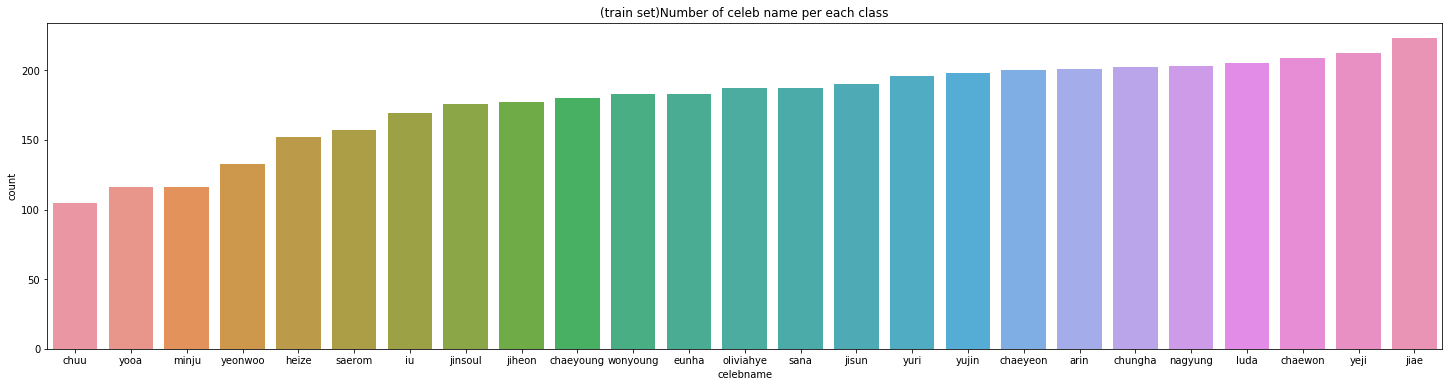

In [12]:
plt.figure(figsize=(25, 6)) # class id가 겹쳐 출력되지 않게 고의로 가로 사이즈를 늘렸습니다.
sns.countplot(train_celeb_df["celebname"], order=train_celeb_df["celebname"].value_counts(ascending=True).index)
plt.title("(train set)Number of celeb name per each class")
plt.show()

## Save both dataframe into `.csv` files.
이제 두 dataframe을 각각 `train.csv`와 `reference.csv`로 저장하겠습니다.

In [13]:
train_celeb_df.to_csv('train.csv')
reference_celeb_df.to_csv('reference.csv')

## Query set 만들고 저장하기

In [14]:
query_dataset_path = './../../../KPopGirls/QueryImages'
query_filenames = os.listdir(query_dataset_path)

In [15]:
query_celebnameonly_list = []

for name in os.listdir(query_dataset_path):
    query_celebnameonly_list.append(re.sub('[^a-zA-Z]', '', str(name.split('.')[0])).replace('query', ''))
    
query_unique_celeb_names = sorted(list(set(query_celebnameonly_list)))
len(query_unique_celeb_names)

25

In [16]:
q_celeb_df = pd.DataFrame(query_filenames, columns=['filename'])
q_celeb_df['celebname'] = q_celeb_df['filename']
q_celeb_df['celebname'] = q_celeb_df['celebname'].str.replace('_query\d+.jpg', '')

In [17]:
q_celeb_df.head(5)

,filename,celebname
0,arin_query001.jpg,arin
1,arin_query002.jpg,arin
2,chaewon_query001.jpg,chaewon
3,chaewon_query002.jpg,chaewon
4,chaeyeon_query001.jpg,chaeyeon


In [18]:
i = 0
q_celeb_df_groups = []

for name, group in q_celeb_df.groupby('celebname'):
    group['class']=i
    i+=1
    q_celeb_df_groups.append(group)
q_celeb_df = pd.concat(q_celeb_df_groups).set_index('filename')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
q_celeb_df.head(5)

,celebname,class
filename,,
arin_query001.jpg,arin,0
arin_query002.jpg,arin,0
chaewon_query001.jpg,chaewon,1
chaewon_query002.jpg,chaewon,1
chaeyeon_query001.jpg,chaeyeon,2


In [20]:
q_celeb_df.to_csv('query.csv')